## Time Accounting for the DDF Program
by Melissa Graham, 2021-11-08

#### 1. Current version of DDF_fixed_scheduler_file.txt (created 2021-11-08)
The CURRENT version of DDF_fixed_scheduler_file.txt was created on 2021-11-08.
The difference from the OLD version is that the first four epochs on the COSMOS field were removed, in order to avoid an oversubscription problem caused by assuming 10 hour nights.

#### 2. OLD version of DDF_fixed_scheduler_file.txt (created at the start of 2021B)
The file OLD_DDF_fixed_scheduler_file.txt was created at the start of 2021B. It assumed 10 hours/night when the truth is 8.3 hours/night, and thus was oversubscribed.

### The contents of this NB
The first part of this NB demonstrates how the CURRENT version of DDF_fixed_scheduler_file.txt will spend the DDF's time over the semester, and not result in oversubscription.
The second part of this NB demonstrates how the OLD version of DDF_fixed_scheduler_file.txt was spending too much time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

In [2]:
### To put a line for today on the plots below, define today's date.
today = '2021-11-08'
today_mjd = Time(today+'T00:00:00.00', format='isot', scale='utc').mjd

### 1. Show how the current DDF fixed schedule file will not spend too much time in 2021B.
"Current" version of DDF_fixed_scheduler_file.txt was made on 2021-11-08.

In [3]:
### Read in data from DDF_fixed_scheduler_file.txt
fsf_date  = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='str', usecols={0} )
fsf_seqid = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='str', usecols={1} )
fsf_dtime = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='float', usecols={4} )

### Grab just the field name from each of the sequence ids
temp = []
for fid in fsf_seqid:
    temp.append( fid.split('-')[0] )
fsf_fname = np.asarray( temp, dtype='str' )
del temp

### Convert the dates to MJD
temp = []
for fdate in fsf_date:
    temp.append( Time(fdate+'T00:00:00.00', format='isot', scale='utc').mjd )
fsf_mjd = np.asarray( temp, dtype='float' )
del temp

In [4]:
print( 'Total planned time is %5.2f hours' % np.sum(fsf_dtime) )
print( 'Assuming 8.3 hours a night, that is %4.2f nights.' % (np.sum(fsf_dtime)/8.3) )
print( 'And the DDF was awarded 7.5 nights.')

Total planned time is 62.88 hours
Assuming 8.3 hours a night, that is 7.58 nights.
And the DDF was awarded 7.5 nights.


In [5]:
### Generate array of cumulative time spent, if the plan is followed
temp = []
for f,fdt in enumerate(fsf_dtime):
    if f == 0:
        temp.append( fsf_dtime[f] )
    else:
        temp.append( temp[f-1]+fsf_dtime[f] )
fsf_dtimeC = np.asarray( temp, dtype='float' )
del temp

In [6]:
### Generate array of IDEAL cumulative time spent
###  which is the total time divided equally between epochs

### Generate array of unique dates (i.e., epochs)
udates = np.unique( fsf_date )
temp = []
for udate in udates:
    temp.append( Time(udate+'T00:00:00.00', format='isot', scale='utc').mjd )
udates_mjd = np.asarray( temp, dtype='float' )
del temp

### Calculate the ideal number of hours per night,
###  using 8.3 hours per night and the assigned 7.5 nights.
awarded_hours = 7.5 * 8.3
number_of_epochs = float( len(udates) )
ideal_hours_per_epoch = awarded_hours / number_of_epochs
str_ihpe = str( np.round(ideal_hours_per_epoch,1) )

### Generate the array of cumulative time spent, in the ideal case
temp = []
for u,udate in enumerate(udates):
    if u == 0:
        temp.append( ideal_hours_per_epoch )
    else:
        temp.append( temp[u-1] + ideal_hours_per_epoch )
udates_ideal_ctime = np.asarray( temp, dtype='float' )
del temp

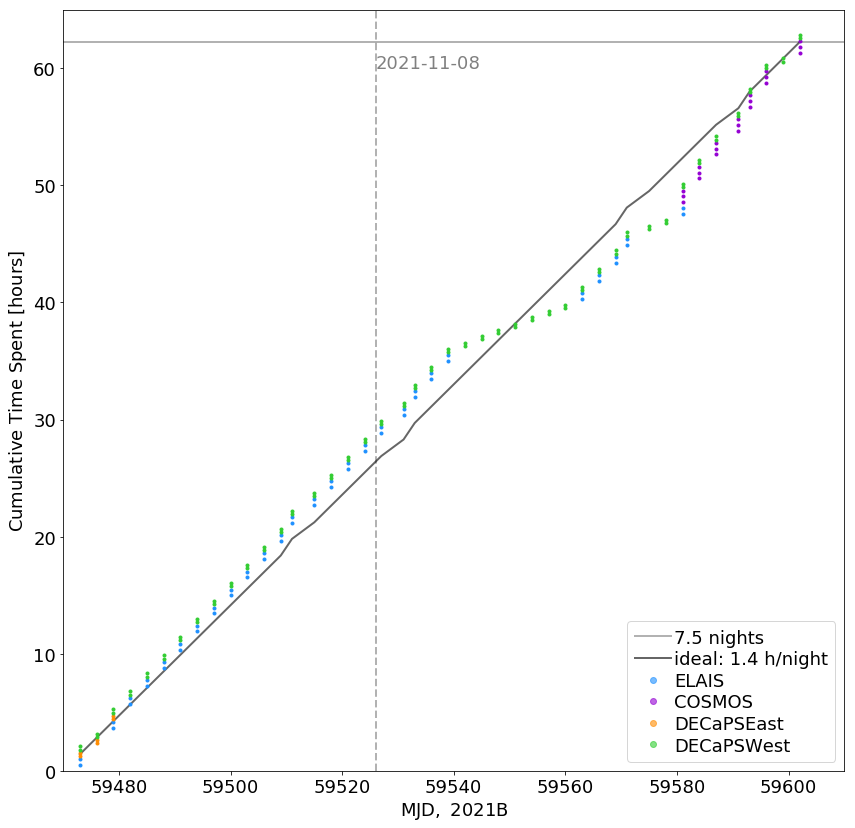

In [7]:
### Plot the cumulative time as a function of MJD over 2021B

fig = plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size':18})

plt.axhline( 7.5*8.3, ls='solid', lw=2, alpha=0.6, color='grey', label='7.5 nights' )
plt.axvline( today_mjd, ls='dashed', lw=2, alpha=0.6, color='grey')
plt.text( today_mjd, 60, today, color='grey')

plt.plot( udates_mjd, udates_ideal_ctime, ls='solid', lw=2, alpha=0.6, color='black', \
         label='ideal: '+str_ihpe+' h/night')

for f in range(len(fsf_mjd)):
    if fsf_fname[f] == 'ELAIS':
        point_color = 'dodgerblue'
    if fsf_fname[f] == 'COSMOS':
        point_color = 'darkviolet'
    if fsf_fname[f] == 'DECaPSEast':
        point_color = 'darkorange'
    if fsf_fname[f] == 'DECaPSWest':
        point_color = 'limegreen'
    plt.plot( fsf_mjd[f], fsf_dtimeC[f], 'o', ms=3, alpha=1, color=point_color )

plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='dodgerblue', label='ELAIS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkviolet', label='COSMOS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkorange', label='DECaPSEast' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='limegreen', label='DECaPSWest' )
    
plt.xlim([59470,59610])
plt.ylim([0,65])
plt.xlabel(r'${\rm MJD,\ 2021B}$',fontsize=18)
plt.ylabel(r'${\rm Cumulative\ Time\ Spent\ [hours]}$',fontsize=18)
plt.legend(loc='best',handletextpad=0.2,labelspacing=0.2,fontsize=18,numpoints=1,ncol=1)
plt.show()

In [8]:
### Clean up
del fsf_date, fsf_seqid, fsf_dtime, fsf_fname, fsf_mjd, fsf_dtimeC
del udates, udates_mjd, udates_ideal_ctime
del awarded_hours, number_of_epochs, ideal_hours_per_epoch, str_ihpe

### 2. Show how the OLD DDF fixed scheduler file would have over-spent for 2021B.
"OLD" version of DDF_fixed_scheduler_file.txt was made at the start of 2021B.

In [9]:
### Read in data from DDF_fixed_scheduler_file.txt
fsf_date  = np.loadtxt( 'OLD_DDF_fixed_scheduler_file.txt', dtype='str', usecols={0} )
fsf_seqid = np.loadtxt( 'OLD_DDF_fixed_scheduler_file.txt', dtype='str', usecols={1} )
fsf_dtime = np.loadtxt( 'OLD_DDF_fixed_scheduler_file.txt', dtype='float', usecols={4} )

### Grab just the field name from each of the sequence ids
temp = []
for fid in fsf_seqid:
    temp.append( fid.split('-')[0] )
fsf_fname = np.asarray( temp, dtype='str' )
del temp

### Convert the dates to MJD
temp = []
for fdate in fsf_date:
    temp.append( Time(fdate+'T00:00:00.00', format='isot', scale='utc').mjd )
fsf_mjd = np.asarray( temp, dtype='float' )
del temp

In [10]:
print( 'Total planned time is %5.2f hours' % np.sum(fsf_dtime) )
print( 'Assuming 10 hours a night, that is %4.2f nights.' % (np.sum(fsf_dtime)/10) )
print( 'But Alfredo said it is 8.3 hours a night, so %4.2f nights.' % (np.sum(fsf_dtime)/8.3) )
print( 'Thus the DDF is over-planned by %4.2f nights, or %4.2f hours.' % \
      ((np.sum(fsf_dtime)/8.3 - 7.5),8.3*(np.sum(fsf_dtime)/8.3 - 7.5)) )

Total planned time is 68.88 hours
Assuming 10 hours a night, that is 6.89 nights.
But Alfredo said it is 8.3 hours a night, so 8.30 nights.
Thus the DDF is over-planned by 0.80 nights, or 6.63 hours.


In [11]:
### Generate array of cumulative time spent, if the plan is followed
temp = []
for f,fdt in enumerate(fsf_dtime):
    if f == 0:
        temp.append( fsf_dtime[f] )
    else:
        temp.append( temp[f-1]+fsf_dtime[f] )
fsf_dtimeC = np.asarray( temp, dtype='float' )
del temp

In [12]:
### Generate array of IDEAL cumulative time spent
###  which is the total time divided equally between epochs

### Generate array of unique dates (i.e., epochs)
udates = np.unique( fsf_date )
temp = []
for udate in udates:
    temp.append( Time(udate+'T00:00:00.00', format='isot', scale='utc').mjd )
udates_mjd = np.asarray( temp, dtype='float' )
del temp

### Calculate the ideal number of hours per night,
###  using 8.3 hours per night and the assigned 7.5 nights.
awarded_hours = 7.5 * 8.3
number_of_epochs = float( len(udates) )
ideal_hours_per_epoch = awarded_hours / number_of_epochs
str_ihpe = str( np.round(ideal_hours_per_epoch,1) )

### Generate the array of cumulative time spent, in the ideal case
temp = []
for u,udate in enumerate(udates):
    if u == 0:
        temp.append( ideal_hours_per_epoch )
    else:
        temp.append( temp[u-1] + ideal_hours_per_epoch )
udates_ideal_ctime = np.asarray( temp, dtype='float' )
del temp

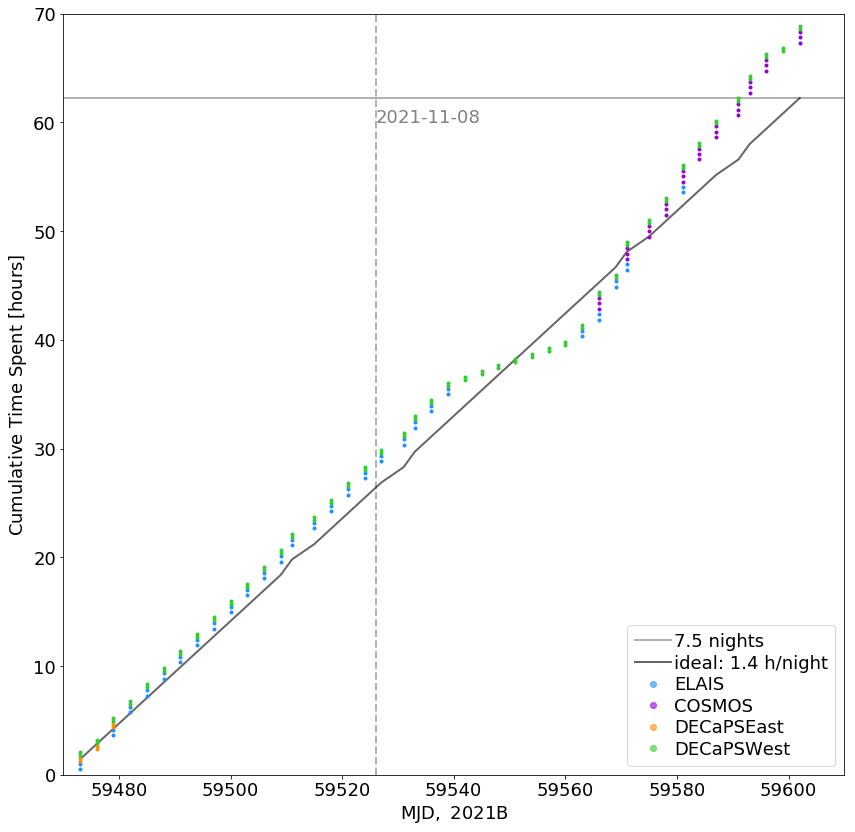

In [13]:
### Plot the cumulative time as a function of MJD over 2021B

fig = plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size':18})

plt.axhline( 7.5*8.3, ls='solid', lw=2, alpha=0.6, color='grey', label='7.5 nights' )
plt.axvline( today_mjd, ls='dashed', lw=2, alpha=0.6, color='grey')
plt.text( today_mjd, 60, today, color='grey')

plt.plot( udates_mjd, udates_ideal_ctime, ls='solid', lw=2, alpha=0.6, color='black', \
         label='ideal: '+str_ihpe+' h/night')

for f in range(len(fsf_mjd)):
    if fsf_fname[f] == 'ELAIS':
        point_color = 'dodgerblue'
    if fsf_fname[f] == 'COSMOS':
        point_color = 'darkviolet'
    if fsf_fname[f] == 'DECaPSEast':
        point_color = 'darkorange'
    if fsf_fname[f] == 'DECaPSWest':
        point_color = 'limegreen'
    plt.plot( fsf_mjd[f], fsf_dtimeC[f], 'o', ms=3, alpha=1, color=point_color )

plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='dodgerblue', label='ELAIS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkviolet', label='COSMOS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkorange', label='DECaPSEast' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='limegreen', label='DECaPSWest' )
    
plt.xlim([59470,59610])
plt.ylim([0,70])
plt.xlabel(r'${\rm MJD,\ 2021B}$',fontsize=18)
plt.ylabel(r'${\rm Cumulative\ Time\ Spent\ [hours]}$',fontsize=18)
plt.legend(loc='best',handletextpad=0.2,labelspacing=0.2,fontsize=18,numpoints=1,ncol=1)
plt.show()

The plot above shows that the COSMOS field was driving the DDF over the time awarded.

In [14]:
### Clean up
del fsf_date, fsf_seqid, fsf_dtime, fsf_fname, fsf_mjd, fsf_dtimeC
del udates, udates_mjd, udates_ideal_ctime
del awarded_hours, number_of_epochs, ideal_hours_per_epoch, str_ihpe